In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, MixedGuidedBridgeProcess
from mixedbridge.solvers.sde import WienerProcess, Euler

In [6]:
dim = 2
T = 4.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
v  = jnp.array([2.0, -0.1], dtype=dtype)

In [7]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc    = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc       = CellDiffusionProcess(alpha=alpha, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc       = CellDiffusionAuxProcess(alpha=alpha, sigma=sigma, T=T, dim=dim, dtype=dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    x0=x0,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=wiener_proc.ts,
    ode_solver_kernel=ode_solver_kernel
)

ori_solver           = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver           = Euler(sde=aux_proc, wiener=wiener_proc)
guided_bridge_solver = Euler(sde=guided_proc, wiener=wiener_proc)

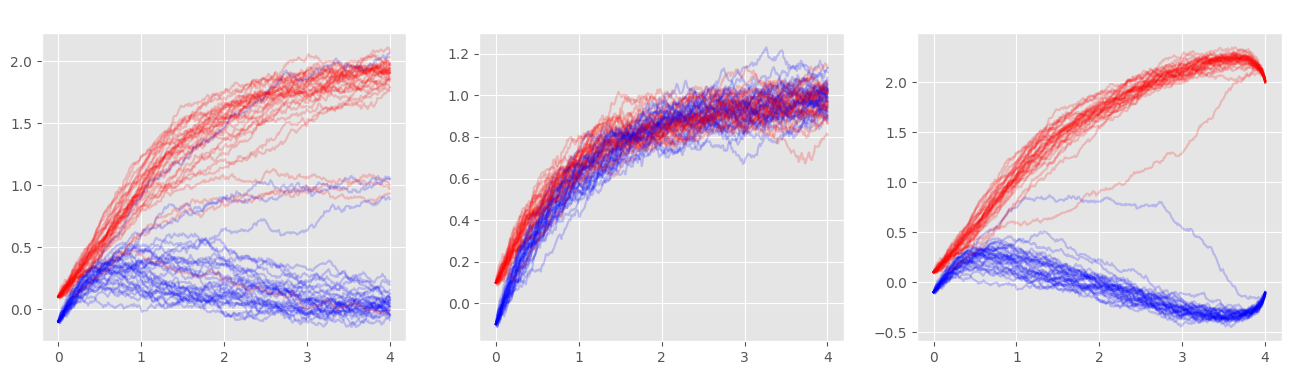

In [39]:
n_samples = 32
ori_path = ori_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)
aux_path = aux_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)
guided_bridge_path = guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i in range(n_samples):
    axs[0].plot(ori_path.ts, ori_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[0].plot(ori_path.ts, ori_path.xs[i, :, 1], color="blue", alpha=0.2)
    axs[1].plot(aux_path.ts, aux_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[1].plot(aux_path.ts, aux_path.xs[i, :, 1], color="blue", alpha=0.2)
    axs[2].plot(guided_bridge_path.ts, guided_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[2].plot(guided_bridge_path.ts, guided_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)
axs[0].set_title("Original Process")
axs[1].set_title("Auxiliary Process")
axs[2].set_title("Guided Process")
plt.show()

In [9]:
from flax import linen as nn
from flax.training import train_state
import optax

In [10]:
# a very simple MLP
class MLP(nn.Module):

    @nn.compact
    def __call__(self, t, x):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20)(x)
        x = nn.tanh(x)
        x = nn.Dense(20)(x)
        x = nn.tanh(x)
        x = nn.Dense(20)(x)
        x = nn.tanh(x)
        x = nn.Dense(2)(x)
        return x

In [28]:
def train_model(rng_key, model, path_solver, n_epochs, n_iters, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 2))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(1e-3)
    )
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs, dWs, log_ll = path.ts, path.xs, path.dWs, path.log_likelihood
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs, dWs, log_ll
    
    def compute_loss(params, ts, xs, dWs, log_ll, state):
        nus = state.apply_fn(params, ts[:, :-1], xs[:, :-1])        # take the left point evaluation
        sto_int = jnp.einsum("...i, ...i -> ...", nus, dWs)
        sto_int = jnp.sum(sto_int, axis=1)
        ll = jnp.exp(log_ll - 200.)
        loss1 = ll * sto_int
        loss2 = 0.5 * ll * jnp.sum(jnp.linalg.norm(nus, axis=-1)**2, axis=1) * dt
        loss = -loss1 + loss2
        return jnp.mean(loss)
    
    # @jax.jit
    def train_step(state, ts, xs, dWs, log_ll):
        grad_fn = jax.value_and_grad(compute_loss, has_aux=False)
        loss, grads = grad_fn(state.params, ts, xs, dWs, log_ll, state)
        state = state.apply_gradients(grads=grads)
        return state, loss, grads
    
    losses = []
    gradient_norms = []
    
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        epoch_losses = []
        epoch_grad_norms = []
        for iter in range(n_iters):
            rng_key, _ = jax.random.split(rng_key)
            ts, xs, dWs, log_ll = sample_path(rng_key, path_solver)
            model_state, loss, grads = train_step(model_state, ts, xs, dWs, log_ll)
            
            if jnp.isnan(loss):
                raise ValueError(f"NaN loss detected. Last valid loss: {losses[-1] if losses else None}")
            
            losses.append(loss)
            epoch_losses.append(loss)
            
            # Compute gradient norm
            grad_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)]))
            
            if jnp.isnan(grad_norm):
                raise ValueError(f"NaN gradient norm detected. Current loss: {losses[-1] if losses else None}, Last valid gradient norm: {gradient_norms[-1] if gradient_norms else None}")
            
            gradient_norms.append(grad_norm)
            epoch_grad_norms.append(grad_norm)
        
        avg_loss = jnp.mean(jnp.array(epoch_losses))
        avg_grad_norm = jnp.mean(jnp.array(epoch_grad_norms))
        print(f"Epoch {epoch:<3} / {n_epochs}, avg loss: {avg_loss:.5f}, avg grad norm: {avg_grad_norm:.5f}, time: {time.time() - start_time:.2f}s")

    return model_state, losses, gradient_norms

In [29]:
model = MLP()
n_epochs = 20
n_iters = 250
batch_size = 128

In [30]:
model_state, losses, gradient_norms = train_model(rng_key, model, guided_bridge_solver, n_epochs, n_iters, batch_size) 

Epoch 1   / 20, avg loss: -0.00335, avg grad norm: 0.01970, time: 51.65s
Epoch 2   / 20, avg loss: -0.00471, avg grad norm: 0.01104, time: 52.80s
Epoch 3   / 20, avg loss: -0.00002, avg grad norm: 0.00004, time: 53.23s
Epoch 4   / 20, avg loss: -0.00000, avg grad norm: 0.00000, time: 53.89s
Epoch 5   / 20, avg loss: -0.00001, avg grad norm: 0.00001, time: 53.44s
Epoch 6   / 20, avg loss: -0.00053, avg grad norm: 0.00058, time: 52.95s
Epoch 7   / 20, avg loss: -0.00000, avg grad norm: 0.00000, time: 55.58s
Epoch 8   / 20, avg loss: -0.00000, avg grad norm: 0.00000, time: 54.27s
Epoch 9   / 20, avg loss: -0.00000, avg grad norm: 0.00001, time: 53.83s
Epoch 10  / 20, avg loss: -0.00001, avg grad norm: 0.00001, time: 53.85s
Epoch 11  / 20, avg loss: -0.00014, avg grad norm: 0.00027, time: 54.52s
Epoch 12  / 20, avg loss: -0.00001, avg grad norm: 0.00001, time: 54.94s
Epoch 13  / 20, avg loss: -0.00001, avg grad norm: 0.00000, time: 56.18s
Epoch 14  / 20, avg loss: -0.00188, avg grad norm: 

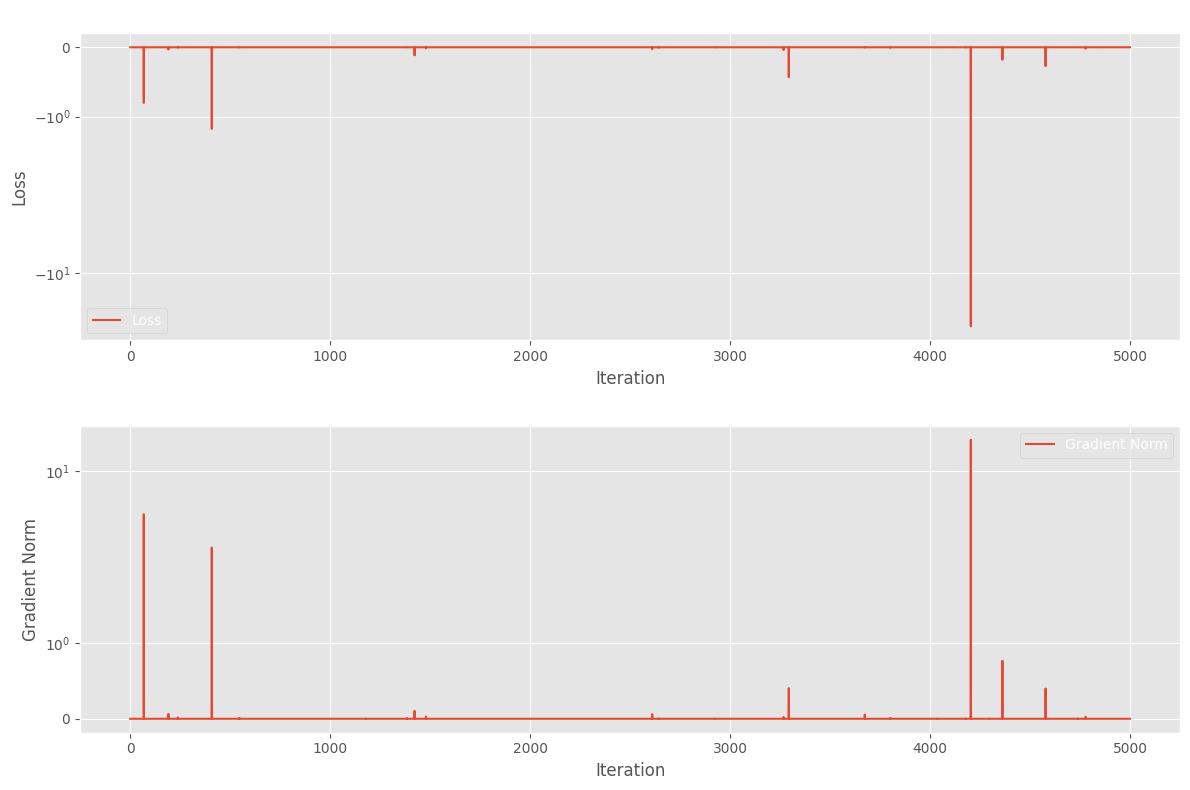

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plotting the losses
ax1.plot(losses, label='Loss')
ax1.set_yscale('symlog')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Iterations')
ax1.legend()
ax1.grid(True)

# Plotting the gradient norms
ax2.plot(gradient_norms, label='Gradient Norm')
ax2.set_yscale('symlog')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Gradient Norm')
ax2.set_title('Gradient Norm over Iterations')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [32]:
def nu_learned(t, x):
    return model_state.apply_fn(model_state.params, t, x) 

In [36]:
mixed_bridge_proc = MixedGuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    x0=x0,
    v=v,
    nu=nu_learned,
    ts=wiener_proc.ts,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
)

mixed_bridge_solver = Euler(sde=mixed_bridge_proc, wiener=wiener_proc)
mixed_bridge_path = mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)

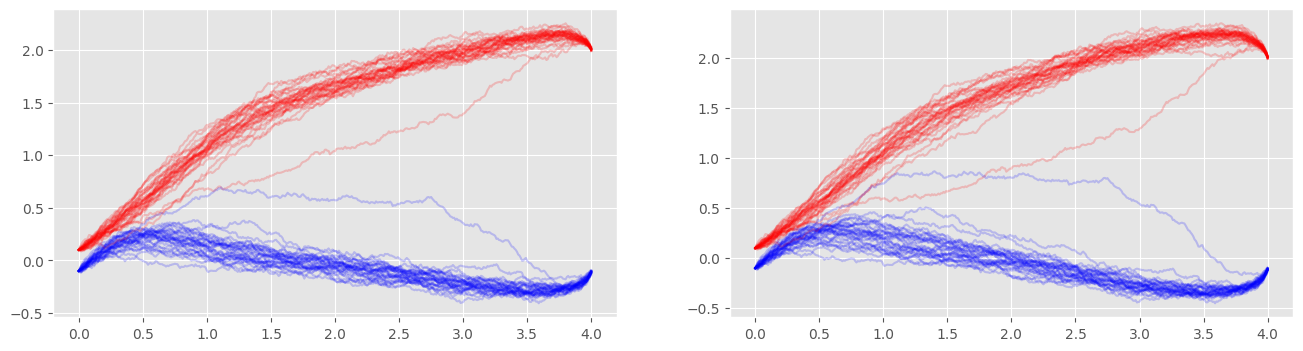

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for i in range(32):
    axs[0].plot(mixed_bridge_path.ts, mixed_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[0].plot(mixed_bridge_path.ts, mixed_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)
    axs[1].plot(guided_bridge_path.ts, guided_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[1].plot(guided_bridge_path.ts, guided_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)